## Visualize video

In [3]:
import cv2
import mediapipe as mp
import os

# Initialize Mediapipe solutions
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

def save_pose_video(video_path, output_path):
    """
    Process a video to detect and draw pose landmarks for the closest person,
    then save the output video.
    
    Args:
        video_path (str): Path to the input video.
        output_path (str): Path to save the processed video.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return

    # Ensure the video starts from the first frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # Initialize Mediapipe Pose
    pose = mp_pose.Pose(
        model_complexity=1,  # Default complexity
        enable_segmentation=False,  # Disable segmentation for faster performance
        smooth_landmarks=True  # Smooth the landmarks for better output
    )

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files

    # Create VideoWriter object
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0  # Counter for frames processed
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Convert the frame to RGB for Mediapipe processing
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        # If pose landmarks are detected
        if results.pose_landmarks and results.pose_world_landmarks:
            # Select the closest person (highest bounding box area)
            landmarks = results.pose_landmarks.landmark

            # Calculate the bounding box area for the detected person
            x_coords = [lmk.x for lmk in landmarks if lmk.visibility > 0.5]
            y_coords = [lmk.y for lmk in landmarks if lmk.visibility > 0.5]
            
            if x_coords and y_coords:
                bbox_area = (max(x_coords) - min(x_coords)) * (max(y_coords) - min(y_coords))
                if bbox_area > 0.01:  # Threshold to filter small detections
                    mp_drawing.draw_landmarks(
                        frame, 
                        results.pose_landmarks, 
                        mp_pose.POSE_CONNECTIONS
                    )
        # else:
        #     print(f"Warning: No pose detected in frame {frame_count}")

        # Write the frame with pose landmarks to the output video
        out.write(frame)

    # Release resources
    cap.release()
    out.release()
    pose.close()
    print(f"Processed {frame_count} frames for {video_path}. Saved to {output_path}")

# Ensure the output folder exists
input_folder = "stage1-dataset"
output_folder = "stage1-dataset-test"
os.makedirs(output_folder, exist_ok=True)

# Iterate over all video files in the input folder
for file_name in os.listdir(input_folder):
    input_video_path = os.path.join(input_folder, file_name)
    
    # Check if the file is a video based on its extension
    if os.path.isfile(input_video_path) and file_name.endswith(('.mp4', '.avi', '.mov', '.mkv')):
        output_video_path = os.path.join(output_folder, file_name)
        save_pose_video(input_video_path, output_video_path)

print(f"All videos in {input_folder} processed and saved to {output_folder}.")


Processed 53 frames for stage1-dataset\user100_brightness.mp4. Saved to stage1-dataset-test\user100_brightness.mp4
Processed 53 frames for stage1-dataset\user100_mirrored.mp4. Saved to stage1-dataset-test\user100_mirrored.mp4
Processed 53 frames for stage1-dataset\user100_noise.mp4. Saved to stage1-dataset-test\user100_noise.mp4
Processed 53 frames for stage1-dataset\user100_rotate.mp4. Saved to stage1-dataset-test\user100_rotate.mp4
Processed 45 frames for stage1-dataset\user101_brightness.mp4. Saved to stage1-dataset-test\user101_brightness.mp4
Processed 45 frames for stage1-dataset\user101_mirrored.mp4. Saved to stage1-dataset-test\user101_mirrored.mp4
Processed 45 frames for stage1-dataset\user101_noise.mp4. Saved to stage1-dataset-test\user101_noise.mp4
Processed 45 frames for stage1-dataset\user101_rotate.mp4. Saved to stage1-dataset-test\user101_rotate.mp4
Processed 34 frames for stage1-dataset\user102_brightness.mp4. Saved to stage1-dataset-test\user102_brightness.mp4
Processed

## Image Interpolation

In [9]:
import cv2
import os
import numpy as np

# Paths
input_folder = "stage4"
output_folder = "stage4-dataset-interpolated"
os.makedirs(output_folder, exist_ok=True)

def interpolate_frames(frame1, frame2, num_interpolations=1):
    """
    Interpolates between two frames using linear interpolation.
    
    Args:
        frame1 (numpy.ndarray): First frame.
        frame2 (numpy.ndarray): Second frame.
        num_interpolations (int): Number of interpolated frames to generate.
    
    Returns:
        list: List of interpolated frames.
    """
    interpolated_frames = []
    for i in range(1, num_interpolations + 1):
        alpha = i / (num_interpolations + 1)  # Interpolation ratio
        interpolated_frame = cv2.addWeighted(frame1, 1 - alpha, frame2, alpha, 0)
        interpolated_frames.append(interpolated_frame)
    return interpolated_frames

def process_video(video_path, output_path, num_interpolations=1):
    """
    Processes a video to add interpolated frames and saves the result.
    
    Args:
        video_path (str): Path to the input video.
        output_path (str): Path to save the interpolated video.
        num_interpolations (int): Number of interpolated frames between each pair of original frames.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video: {video_path}")
        return
    
    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files
    
    # New FPS after interpolation
    new_fps = fps * (num_interpolations + 1)
    out = cv2.VideoWriter(output_path, fourcc, new_fps, (width, height))
    
    ret, prev_frame = cap.read()
    while ret:
        ret, next_frame = cap.read()
        if not ret:
            break

        # Write the original frame
        out.write(prev_frame)

        # Generate and write interpolated frames
        interpolated_frames = interpolate_frames(prev_frame, next_frame, num_interpolations)
        for frame in interpolated_frames:
            out.write(frame)
        
        # Update the previous frame
        prev_frame = next_frame

    # Release resources
    cap.release()
    out.release()
    print(f"Interpolated video saved to: {output_path}")

# Process all videos in the input folder
num_interpolations = 3  # Number of interpolated frames between each pair
for video_file in os.listdir(input_folder):
    if video_file.endswith(".mp4"):
        input_path = os.path.join(input_folder, video_file)
        output_path = os.path.join(output_folder, video_file)
        process_video(input_path, output_path, num_interpolations=num_interpolations)

print("Interpolation complete for all videos.")


Interpolated video saved to: stage4-dataset-interpolated\user1.mp4
Interpolated video saved to: stage4-dataset-interpolated\user10.mp4
Interpolated video saved to: stage4-dataset-interpolated\user102.mp4
Interpolated video saved to: stage4-dataset-interpolated\user103.mp4
Interpolated video saved to: stage4-dataset-interpolated\user11.mp4
Interpolated video saved to: stage4-dataset-interpolated\user12.mp4
Interpolated video saved to: stage4-dataset-interpolated\user13.mp4
Interpolated video saved to: stage4-dataset-interpolated\user14.mp4
Interpolated video saved to: stage4-dataset-interpolated\user17.mp4
Interpolated video saved to: stage4-dataset-interpolated\user19.mp4
Interpolated video saved to: stage4-dataset-interpolated\user2.mp4
Interpolated video saved to: stage4-dataset-interpolated\user20.mp4
Interpolated video saved to: stage4-dataset-interpolated\user21.mp4
Interpolated video saved to: stage4-dataset-interpolated\user22.mp4
Interpolated video saved to: stage4-dataset-inte

## Visualize one video

In [7]:
import cv2
import mediapipe as mp
import os

# Initialize Mediapipe solutions
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

def save_pose_video(video_path, output_path):
    """
    Process a video to detect and draw pose landmarks, then save the output video.
    
    Args:
        video_path (str): Path to the input video.
        output_path (str): Path to save the processed video.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return

    # Ensure the video starts from the first frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # Initialize Mediapipe Pose
    pose = mp_pose.Pose(
        model_complexity=1,  # Default complexity
        enable_segmentation=False,  # Disable segmentation for faster performance
        smooth_landmarks=True  # Smooth the landmarks for better output
    )

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files

    # Create VideoWriter object
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0  # Counter for frames processed
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Convert the frame to RGB for Mediapipe processing
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        # Draw pose landmarks on the frame
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame, 
                results.pose_landmarks, 
                mp_pose.POSE_CONNECTIONS
            )
      #   else:
      #       print(f"Warning: No pose detected in frame {frame_count}")

        # Write the frame with pose landmarks to the output video
        out.write(frame)

    # Release resources
    cap.release()
    out.release()
    pose.close()
    print(f"Processed {frame_count} frames. Saved to {output_path}")

# Ensure the output folder exists
output_folder = "stage4-test"
os.makedirs(output_folder, exist_ok=True)

# Paths
input_video_path = "stage4/user21.mp4"
output_video_path = os.path.join(output_folder, "user22_pose.mp4")

# Process and save the video
save_pose_video(input_video_path, output_video_path)
print(f"Saved the processed video to {output_video_path}")


Processed 46 frames. Saved to stage4-test\user22_pose.mp4
Saved the processed video to stage4-test\user22_pose.mp4


## Frames count

In [2]:
import cv2
import os

# Path to the folder containing the videos
stage_path = "stage5-40-frames"

# List to store the number of frames for each video
frame_counts = []

# Iterate through the videos in the folder
for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        
        # Open the video file
        cap = cv2.VideoCapture(video_file_path)
        
        if not cap.isOpened():
            print(f"Error opening video file: {file}")
            continue

        # Get the total number of frames
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_counts.append(total_frames)

        cap.release()

# Calculate average, minimum, and maximum frame counts
if frame_counts:
    avg_frames = sum(frame_counts) / len(frame_counts)
    min_frames = min(frame_counts)
    max_frames = max(frame_counts)

    print(f"Average frames per video: {avg_frames:.2f}")
    print(f"Minimum frames in a video: {min_frames}")
    print(f"Maximum frames in a video: {max_frames}")
else:
    print("No valid videos found in the specified folder.")


Average frames per video: 40.00
Minimum frames in a video: 40
Maximum frames in a video: 40


## Standardize videos

In [ ]:
import cv2
import os

# Path to input and output directories
input_dir = "stage1-dataset-interpolated"
output_dir = "stage1-dataset-70frames"
os.makedirs(output_dir, exist_ok=True)

target_frames = 70  # Target number of frames per video

def truncate_or_pad_video(video_path, output_path, target_frames):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create VideoWriter for the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    if len(frames) < target_frames:
        # Pad by duplicating frames
        while len(frames) < target_frames:
            frames.append(frames[-1])  # Duplicate the last frame
    elif len(frames) > target_frames:
        # Truncate to the last 70 frames
        frames = frames[-target_frames:]

    # Write the processed frames to the output video
    for frame in frames:
        out.write(frame)
    out.release()

# Process all videos in the input directory
for file in os.listdir(input_dir):
    if file.endswith(".mp4"):
        input_path = os.path.join(input_dir, file)
        output_path = os.path.join(output_dir, file)
        truncate_or_pad_video(input_path, output_path, target_frames)

print("All videos resized to exactly 70 frames using truncate or pad method.")


All videos resized to exactly 70 frames using truncate or pad method.


In [12]:
import cv2
import os

# Path to input and output directories
input_dir = "stage4-dataset-interpolated"
output_dir = "stage4-dataset-130frames"
os.makedirs(output_dir, exist_ok=True)

target_frames = 130  # Target number of frames per video

def truncate_or_pad_video(video_path, output_path, target_frames):
    """
    Truncate or pad a video to ensure it has exactly `target_frames` frames.

    Args:
        video_path (str): Path to the input video.
        output_path (str): Path to save the processed video.
        target_frames (int): Desired number of frames.
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create VideoWriter for the output video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    if len(frames) < target_frames:
        # Pad by duplicating frames
        while len(frames) < target_frames:
            frames.append(frames[-1])  # Duplicate the last frame
    elif len(frames) > target_frames:
        # Truncate to the first 130 frames
        frames = frames[:target_frames]

    # Write the processed frames to the output video
    for frame in frames:
        out.write(frame)
    out.release()

# Process all videos in the input directory
for file in os.listdir(input_dir):
    if file.endswith(".mp4"):
        input_path = os.path.join(input_dir, file)
        output_path = os.path.join(output_dir, file)
        truncate_or_pad_video(input_path, output_path, target_frames)

print("All videos resized to exactly 130 frames using truncate or pad method.")


All videos resized to exactly 130 frames using truncate or pad method.


## Augmentation

In [3]:
import cv2
import os
import pandas as pd
import numpy as np

# Paths
input_folder = "stage5-40-frames"
output_folder = "stage5-dataset"
os.makedirs(output_folder, exist_ok=True)

# Load labels
labels_df = pd.read_csv("stage5.csv")

# Augmentation Functions
def augment_video(video_path, output_path, augmentation_type, is_odd):
    """
    Augment the video with the specified augmentation type and save it.
    
    Args:
        video_path (str): Path to the input video.
        output_path (str): Path to save the augmented video.
        augmentation_type (str): Type of augmentation ('rotate', 'brightness', 'noise', etc.).
        is_odd (bool): Whether the video index is odd or even.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_path}")
        return

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files

    # Create VideoWriter object
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Apply augmentation
        if augmentation_type == "mirrored":
            frame = cv2.flip(frame, 1)  # Horizontal flip
        elif augmentation_type == "rotate":
            angle = 3 if is_odd else -3  # Adjusted rotation angles
            M = cv2.getRotationMatrix2D((width // 2, height // 2), angle, 1)
            frame = cv2.warpAffine(frame, M, (width, height))
        elif augmentation_type == "brightness":
            alpha = 1.05 if is_odd else 0.95  # Adjusted brightness
            frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=0)
        elif augmentation_type == "noise":
            noise = np.random.normal(0, 0.05, frame.shape).astype(np.uint8)  # Add small random noise
            frame = cv2.add(frame, noise)

        # Write the augmented frame
        out.write(frame)

    cap.release()
    out.release()

# Augment videos and create a new CSV file
augmented_data = []
for idx, row in labels_df.iterrows():
    video_path = row['video']
    label = row['label']
    base_name = os.path.splitext(os.path.basename(video_path))[0]

    # Original video path
    input_video_path = os.path.join(input_folder, os.path.basename(video_path))
    is_odd = (idx % 2 == 1)

    # Add original video to the dataset
    original_video_path = os.path.join(output_folder, f"{base_name}_original.mp4")
    if not os.path.exists(original_video_path):
        cap = cv2.VideoCapture(input_video_path)
        if cap.isOpened():
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = int(cap.get(cv2.CAP_PROP_FPS))
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(original_video_path, fourcc, fps, (width, height))
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                out.write(frame)
            cap.release()
            out.release()
    augmented_data.append({
        "video": original_video_path,
        "label": label
    })

    # Apply augmentations
    for aug_type in ["mirrored", "rotate", "brightness", "noise"]:
        output_video_name = f"{base_name}_{aug_type}.mp4"
        output_video_path = os.path.join(output_folder, output_video_name)
        augment_video(input_video_path, output_video_path, aug_type, is_odd)

        # Append to dataset
        augmented_data.append({
            "video": output_video_path,
            "label": label
        })

# Create a new DataFrame for augmented dataset
augmented_df = pd.DataFrame(augmented_data)

# Save the new dataset labels to a CSV file
augmented_df.to_csv("stage1-dataset.csv", index=False)
print("Augmented videos saved to stage1-dataset and labels saved to stage1-dataset.csv.")


Augmented videos saved to stage1-dataset and labels saved to stage1-dataset.csv.


## Keypoints extraction

In [2]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to calculate angle between three points
def calculate_angle(a, b, c):
    """
    Calculate the angle formed by three points (a, b, c) where 'b' is the vertex.
    """
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))  # Clip to avoid numerical errors
    return np.degrees(angle)

# Paths
stage_path = "stage1-dataset"  # Path to input videos
output_path = "stage1-dataset-json"  # Path to save output JSON files
os.makedirs(output_path, exist_ok=True)

# Process videos in the stage path
for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video
        # frame_skip = 7  # Process every 7th frame
        # frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # if frame_count % frame_skip != 0:
            #     frame_count += 1
            #     continue

            # Convert frame to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract relevant keypoints
                left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x,
                                 landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
                right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x,
                                  landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
                left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP].x,
                            landmarks[mp_pose.PoseLandmark.LEFT_HIP].y]
                right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
                             landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]
                nose = [landmarks[mp_pose.PoseLandmark.NOSE].x,
                        landmarks[mp_pose.PoseLandmark.NOSE].y]

                # Calculate average positions
                pelvis_avg_y = (left_hip[1] + right_hip[1]) / 2
                shoulders_avg_y = (left_shoulder[1] + right_shoulder[1]) / 2

                # Highest points for pelvis and shoulders
                highest_pelvis_y = min(left_hip[1], right_hip[1])  # Lower y-value is higher on the screen
                highest_shoulder_y = min(left_shoulder[1], right_shoulder[1])

                # Define thresholds for acceptable height difference between highest points
                min_highest_threshold = 0.03  # Minimum acceptable difference
                max_highest_threshold = 0.10  # Maximum acceptable difference

                # Calculate relative difference
                highest_relative_difference = highest_shoulder_y - highest_pelvis_y

                # Determine if highest points comparison is good (1) or bad (0)
                if min_highest_threshold <= highest_relative_difference <= max_highest_threshold:
                    highest_points_good = 1  # Good position
                else:
                    highest_points_good = 0  # Bad position (too low or too high)

                # Define thresholds for acceptable pelvis-to-shoulders average difference
                min_avg_threshold = 0.03  # Minimum acceptable difference
                max_avg_threshold = 0.16   # Maximum acceptable difference

                # Calculate relative difference for average heights
                avg_relative_difference = shoulders_avg_y - pelvis_avg_y

                # Determine if pelvis-to-shoulders average position is good (1) or bad (0)
                if min_avg_threshold <= avg_relative_difference <= max_avg_threshold:
                    pelvis_higher_than_shoulders = 1  # Good position
                else:
                    pelvis_higher_than_shoulders = 0  # Bad position (too low or too high)

                # Calculate torso angle
                torso_angle = calculate_angle(left_shoulder, left_hip, right_hip)

                # Store data for this frame
                keypoints_data.append({
                    "frame": int(cap.get(cv2.CAP_PROP_POS_FRAMES)),
                    "pelvis_avg_y": pelvis_avg_y,
                    "shoulders_avg_y": shoulders_avg_y,
                    "highest_pelvis_y": highest_pelvis_y,
                    "highest_shoulder_y": highest_shoulder_y,
                    "highest_relative_difference": highest_relative_difference,
                    "highest_points_good": highest_points_good,
                    "pelvis_higher_than_shoulders": pelvis_higher_than_shoulders,
                    "torso_angle": torso_angle
                })

            # frame_count += 1

        # Release the video
        cap.release()

        # Save keypoints to a JSON file
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(output_path, json_filename)
        with open(json_path, "w") as json_file:
            json.dump(keypoints_data, json_file, indent=4)

print("Keypoints extraction completed and saved as JSON.")


Keypoints extraction completed and saved as JSON.


## Model training

In [10]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset
dataset = pd.read_csv("stage1-dataset.csv")

# Map labels to numerical values
label_mapping = {"correct": 0, "incorrect": 1}
dataset['label'] = dataset['label'].map(label_mapping)

# Define paths
json_folder = "stage1-dataset-json"

# Prepare features and labels
X = []
y = []
video_names = []  # For error analysis

# Updated feature extraction loop with error handling
for _, row in dataset.iterrows():
    video_name = os.path.basename(row['video'])
    label = row['label']
    json_file = os.path.join(json_folder, video_name.replace(".mp4", "_keypoints.json"))
    
    # Load JSON data
    try:
        with open(json_file, "r") as file:
            data = json.load(file)
    except FileNotFoundError:
        print(f"JSON file not found: {json_file}")
        continue
    
    # Extract selected features and handle missing keys
    features = []
    for frame in data:
        try:
            # Extract required features
            pelvis_avg_y = frame["pelvis_avg_y"]
            shoulders_avg_y = frame["shoulders_avg_y"]
            torso_angle = frame.get("torso_angle", 0.0)  # Default to 0.0 if key is missing
            pelvis_higher_than_shoulders = 1 if frame["pelvis_higher_than_shoulders"] else 0
            highest_points_good = 1 if frame["highest_points_good"] else 0  # Include highest_points_good

            # Derived features
            shoulder_pelvis_diff = shoulders_avg_y - pelvis_avg_y  # Difference in heights
            relative_pelvis_height = (pelvis_avg_y - shoulders_avg_y) / (
                abs(shoulders_avg_y - pelvis_avg_y) + 1e-6
            )  # Normalized difference

            # Append the features
            features.append([
                pelvis_avg_y,
                shoulders_avg_y,
                shoulder_pelvis_diff,
                relative_pelvis_height,
                torso_angle,
                pelvis_higher_than_shoulders,
                highest_points_good  # Include highest_points_good as a feature
            ])
        except KeyError as e:
            print(f"Missing key {e} in frame: {frame}")
            continue
    
    # Append to feature and label lists
    if features:  # Only append if features are not empty
        X.append(features)
        y.append(label)
        video_names.append(video_name)

# Pad sequences to ensure uniform length
max_sequence_length = 70  # Ensure uniform length
X = pad_sequences(X, maxlen=max_sequence_length, dtype='float32', padding='post', truncating='post')

# Convert to numpy array
X = np.array(X)
y = np.array(y)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

# Model Constants
sequence_length = X_train.shape[1]  # Fixed length of sequences
num_features = X_train.shape[2]  # Number of features per frame
num_classes = len(np.unique(y_train))  # Number of unique labels

# Output shapes for validation
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (92, 70, 7)
X_val shape: (23, 70, 7)
y_train shape: (92,)
y_val shape: (23,)


In [60]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
class_labels = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=y_train
)
class_weights_dict = dict(zip(class_labels, class_weights))

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.477124183006536, 1: 2.7037037037037037, 2: 1.8717948717948718}


In [12]:
# Build the LSTM model
# model = Sequential([
#     LSTM(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, num_features)),
#     Dropout(0.3),  # Regularization to prevent overfitting
#     LSTM(64, activation='tanh', return_sequences=False),
#     Dropout(0.3),
#     Dense(64, activation='relu'),  # Fully connected layer
#     Dropout(0.2),
#     Dense(num_classes, activation='softmax')  # Use 'softmax' for multi-class classification
# ])
# accuracy 52%


# model = Sequential([
#     LSTM(256, activation='tanh', return_sequences=True, input_shape=(sequence_length, num_features)),
#     Dropout(0.3),
#     LSTM(128, activation='tanh', return_sequences=True),
#     Dropout(0.3),
#     LSTM(64, activation='tanh', return_sequences=False),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(num_classes, activation='softmax')

# ])

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2), input_shape=(sequence_length, num_features)),
    Bidirectional(LSTM(128, dropout=0.2)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Predict a value between 0 and 1
])


# model.compile(
#     optimizer=Adam(learning_rate=0.0005),
#     loss='mse', 
#     metrics=['mae']
# )
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # Adjust based on dataset size
    batch_size=16,  # Adjust based on memory constraints
    # callbacks=[early_stopping],
    # class_weight=class_weights_dict,
    verbose=1
)

# Save the model
model.save("pose_lstm_model.h5")
print("Model training complete and saved as 'pose_lstm_model.h5'")

Epoch 1/200
6/6 [==============================] - 20s 2s/step - loss: 1.2068 - mae: 0.4618 - val_loss: 1.1471 - val_mae: 0.4191
Epoch 2/200
6/6 [==============================] - 11s 2s/step - loss: 1.1247 - mae: 0.4138 - val_loss: 1.0358 - val_mae: 0.4434
Epoch 3/200
6/6 [==============================] - 15s 3s/step - loss: 1.0099 - mae: 0.4590 - val_loss: 0.9485 - val_mae: 0.4622
Epoch 4/200
6/6 [==============================] - 13s 2s/step - loss: 0.9168 - mae: 0.4311 - val_loss: 0.8671 - val_mae: 0.4307
Epoch 5/200
6/6 [==============================] - 12s 2s/step - loss: 0.8352 - mae: 0.4241 - val_loss: 0.7905 - val_mae: 0.4356
Epoch 6/200


KeyboardInterrupt: 

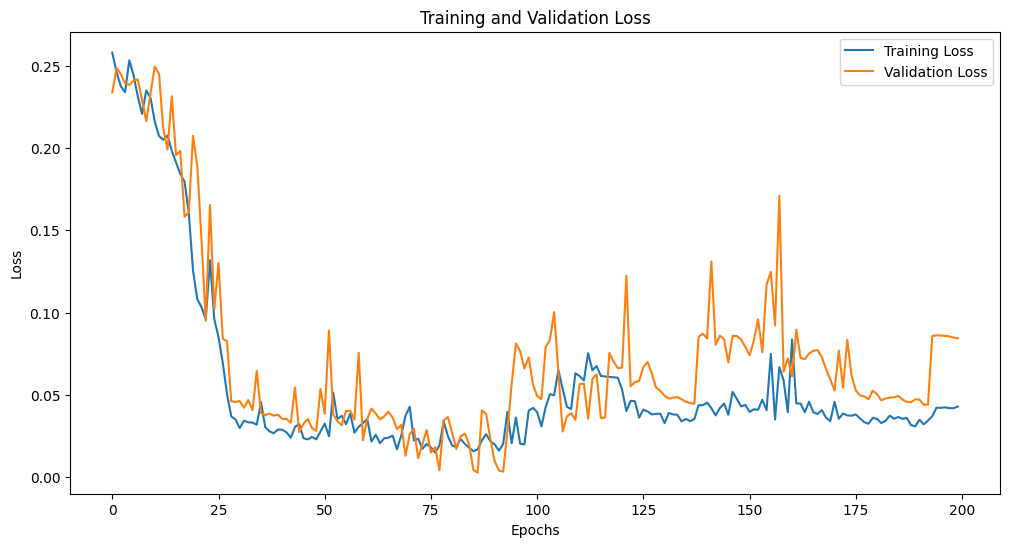

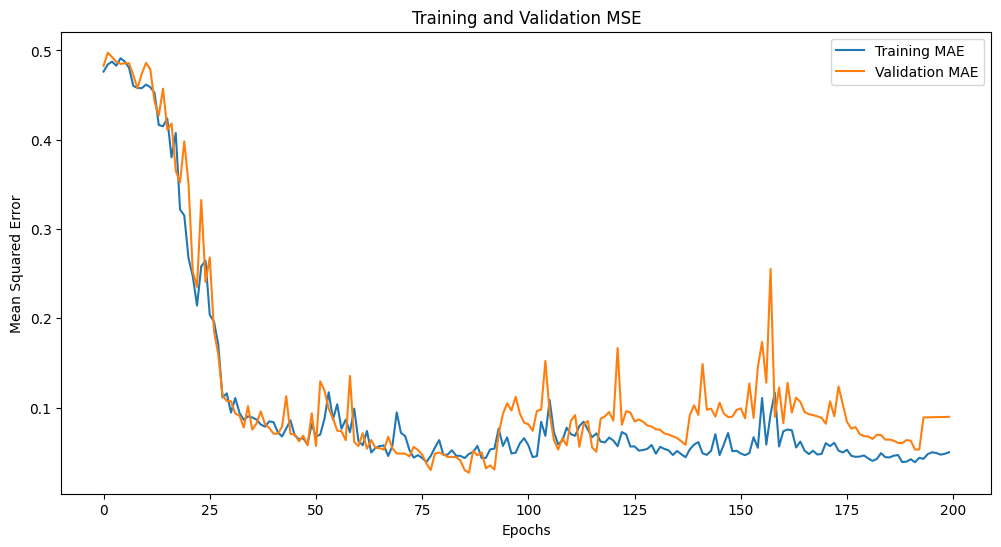

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation MSE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [12]:
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix

# Define threshold
threshold = 0.5  # Predictions above this are classified as `correct` (0), below as `incorrect` (1)

# Load the trained model
model = load_model("stage1.h5")

# Predict on validation set
y_pred = model.predict(X_val).flatten()  # Flatten the predictions for simplicity

# Apply threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # 0 = correct, 1 = incorrect

y_classified = []
for pred in y_pred:
    if pred > threshold:
        y_classified.append(1)  # Correct
    else:
        y_classified.append(0)  # Incorrect
print(y_classified)

# Convert to a DataFrame for easy analysis
results_df = pd.DataFrame({
    'True Label': y_val,
    'Predicted Value': y_pred,
    'Predicted Class': y_classified
})

# Save results to a CSV file for analysis
results_df.to_csv("validation_results.csv", index=False)
print("Validation results saved to 'validation_results.csv'.")

# Display the first few rows
print(results_df.head())

# Calculate and display accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_classified)
print("Confusion Matrix:")
print(conf_matrix)


1/1 [==============================] - 1s 549ms/step
[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]
Validation results saved to 'validation_results.csv'.
   True Label  Predicted Value  Predicted Class
0           1         0.983896                1
1           1         0.991276                1
2           0         0.002241                0
3           0         0.004245                0
4           0         0.000772                0
Accuracy: 0.91
Confusion Matrix:
[[15  2]
 [ 0  6]]


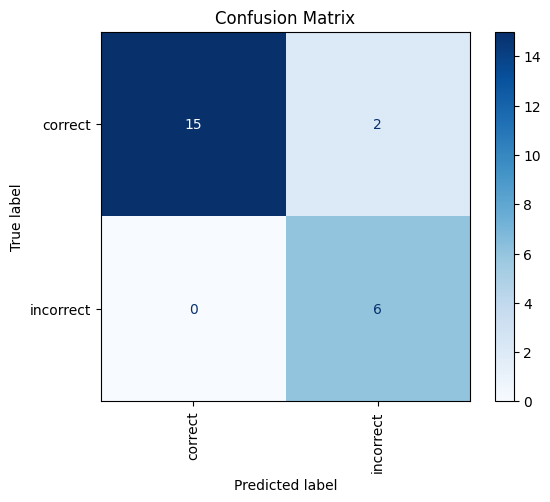

Accuracy: 0.91


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Define a single threshold for classification
threshold = 0.005  # Adjust this value to experiment with different thresholds

# Classify predictions based on the threshold
# y_classified = [0 if pred > threshold else 1 for pred in y_pred]  # `0` = correct, `1` = incorrect

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    # Ensure label order matches the data
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Numerical order: 0 = correct, 1 = incorrect
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

# Ensure the order of labels matches the confusion matrix
true_labels = ["correct", "incorrect"]  # Match this to 0 = correct, 1 = incorrect

# Plot confusion matrix
plot_confusion_matrix(y_val, y_classified, labels=true_labels)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_classified)
print(f"Accuracy: {accuracy:.2f}")


In [26]:
# Check the distribution of true labels in y_val
unique_labels, counts = np.unique(y_val, return_counts=True)
print(f"True Labels Distribution: {dict(zip(unique_labels, counts))}")

# Check the distribution of predicted labels in y_classified
pred_unique_labels, pred_counts = np.unique(y_classified, return_counts=True)
print(f"Predicted Labels Distribution: {dict(zip(pred_unique_labels, pred_counts))}")


True Labels Distribution: {0: 15, 1: 8}
Predicted Labels Distribution: {0: 10, 1: 13}


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.compat.v1.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to handle data imbalance
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weights_dict}")

# Build the LSTM model with L2 regularization
model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),  # Add L2 regularization
    Dropout(0.3),
    Dense(64, activation='relu'),  # Add L2 regularization to dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Output: Value between 0 and 1
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # Adjust based on dataset size
    batch_size=16,  # Adjust based on memory constraints
    class_weight=class_weights_dict,  # Use class weights to address imbalance
    # callbacks=[early_stopping],  # Early stopping to prevent overfitting
    verbose=1
)

# Save the model
model.save("stage1.keras")
print("Model training complete and saved as 'stage1.keras'")


Class weights: {0: 0.6764705882352942, 1: 1.9166666666666667}
Epoch 1/200
6/6 [==============================] - 8s 845ms/step - loss: 0.2514 - mae: 0.4903 - val_loss: 0.2426 - val_mae: 0.4915
Epoch 2/200
6/6 [==============================] - 5s 857ms/step - loss: 0.2378 - mae: 0.4883 - val_loss: 0.2412 - val_mae: 0.4887
Epoch 3/200
6/6 [==============================] - 4s 712ms/step - loss: 0.2418 - mae: 0.4863 - val_loss: 0.2351 - val_mae: 0.4817
Epoch 4/200
6/6 [==============================] - 5s 856ms/step - loss: 0.2465 - mae: 0.4841 - val_loss: 0.2343 - val_mae: 0.4790
Epoch 5/200
6/6 [==============================] - 5s 860ms/step - loss: 0.2403 - mae: 0.4779 - val_loss: 0.2384 - val_mae: 0.4804
Epoch 6/200
6/6 [==============================] - 8s 1s/step - loss: 0.2255 - mae: 0.4686 - val_loss: 0.2441 - val_mae: 0.4835
Epoch 7/200
6/6 [==============================] - 9s 2s/step - loss: 0.2266 - mae: 0.4810 - val_loss: 0.2581 - val_mae: 0.4945
Epoch 8/200
6/6 [==========

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

# Constants
sequence_length = X_train.shape[1]  # Number of frames per video
num_features = X_train.shape[2]  # Number of features per frame
num_classes = len(np.unique(y_train))  # Number of unique labels

# Build the LSTM model
model = Sequential([
    # LSTM(64, input_shape=(sequence_length, num_features), return_sequences=True),
    # Dropout(0.2),  # Regularization to prevent overfitting
    # LSTM(64, return_sequences=False),
    # Dropout(0.2),
    # Dense(32, activation='relu'),
    # Dense(num_classes, activation='softmax')  # Use 'softmax' for multiclass classification
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(sequence_length, num_features)),
    Dropout(0.2),  # Regularization to prevent overfitting
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),  # Fully connected layer
    Dense(num_classes, activation='softmax')  # Use 'softmax' for multi-class classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',  # Suitable for integer-encoded labels
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=20,  # Adjust based on dataset size
#     batch_size=16,  # Adjust based on memory constraints
#     # callbacks=[early_stopping],
#     verbose=1
# )

# model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,  # Adjust based on dataset size
    batch_size=16,  # Adjust based on memory constraints
    verbose=1
)

# Save the model
model.save("pose_lstm_model.h5")
print("Model training complete and saved as 'pose_lstm_model.h5'")

Epoch 1/20
5/5 [==============================] - 11s 1s/step - loss: 1.0961 - accuracy: 0.6164 - val_loss: 1.0877 - val_accuracy: 0.6842
Epoch 2/20
5/5 [==============================] - 4s 901ms/step - loss: 1.0846 - accuracy: 0.6438 - val_loss: 1.0719 - val_accuracy: 0.6842
Epoch 3/20
5/5 [==============================] - 5s 960ms/step - loss: 1.0673 - accuracy: 0.6438 - val_loss: 1.0470 - val_accuracy: 0.6842
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 1.0420 - accuracy: 0.6438 - val_loss: 0.9990 - val_accuracy: 0.6842
Epoch 5/20
5/5 [==============================] - 6s 1s/step - loss: 0.9893 - accuracy: 0.6438 - val_loss: 0.9081 - val_accuracy: 0.6842
Epoch 6/20
5/5 [==============================] - 4s 936ms/step - loss: 0.9416 - accuracy: 0.6438 - val_loss: 0.8684 - val_accuracy: 0.6842
Epoch 7/20
5/5 [==============================] - 4s 895ms/step - loss: 0.9446 - accuracy: 0.6438 - val_loss: 0.8624 - val_accuracy: 0.6842
Epoch 8/20
5/5 [============

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Evaluate the model on the validation set
model = load_model("stage1.h5")
val_predictions = model.predict(X_val)  # Softmax output probabilities
val_predicted_classes = np.argmax(val_predictions, axis=1)  # Predicted classes

# Display misclassified examples
misclassified_indices = np.where(val_predicted_classes != y_val)[0]  # Indices of misclassified examples

# Example display: misclassified users
print("Misclassified Examples:")
for idx in misclassified_indices:
    print(f"Index: {idx}, Actual: {y_val[idx]}, Predicted: {val_predicted_classes[idx]}")

# Assuming `y_val_users` contains the usernames or labels corresponding to each sample in the validation set
# If you have usernames in a separate array or dataset, associate them here
y_val_users = ...  # Replace with actual user IDs or names
misclassified_users = [y_val_users[idx] for idx in misclassified_indices]

print("\nUsers who were misclassified:")
print(misclassified_users)

# Optional: Display specific misclassified examples
import matplotlib.pyplot as plt

for idx in misclassified_indices[:5]:  # Display the first 5 misclassified examples
    print(f"Example {idx} - Actual: {y_val[idx]}, Predicted: {val_predicted_classes[idx]}")
    plt.plot(X_val[idx])  # Plot the feature sequence for this example
    plt.title(f"Actual: {y_val[idx]} vs Predicted: {val_predicted_classes[idx]}")
    plt.xlabel("Frame")
    plt.ylabel("Feature Value")
    plt.show()


1/1 [==============================] - 1s 734ms/step
Misclassified Examples:
Index: 0, Actual: 1, Predicted: 0
Index: 1, Actual: 1, Predicted: 0
Index: 5, Actual: 1, Predicted: 0
Index: 7, Actual: 1, Predicted: 0
Index: 14, Actual: 1, Predicted: 0
Index: 22, Actual: 1, Predicted: 0


TypeError: 'ellipsis' object is not subscriptable

1/1 [==============================] - 1s 689ms/step


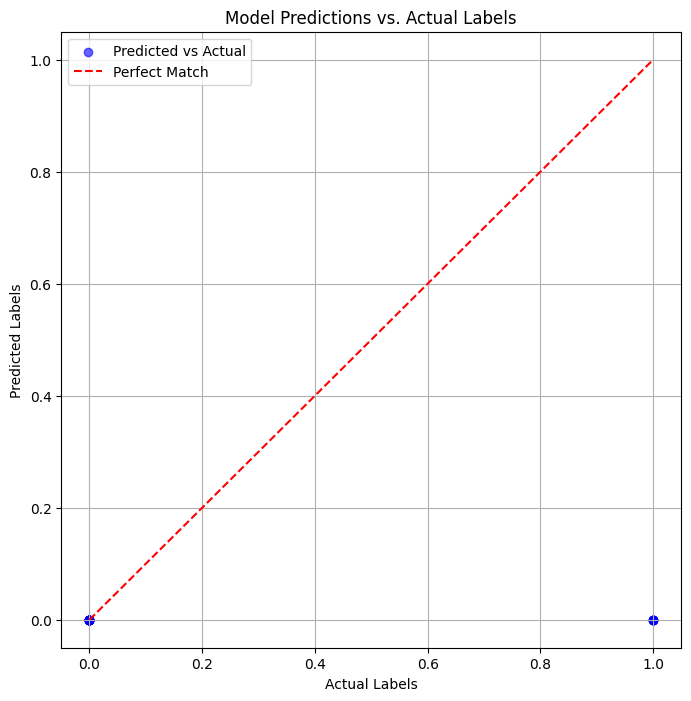

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions for the validation set
model = load_model("stage1.h5")
predictions = model.predict(X_val)

# If predictions are probabilities, convert them to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Scatter plot of predictions vs. actual
plt.figure(figsize=(8, 8))
plt.scatter(y_val, predicted_labels, c='blue', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Model Predictions vs. Actual Labels')
plt.legend()
plt.grid()
plt.show()


In [6]:
!nvidia-smi 

Mon Jan 13 02:31:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0             16W /   88W |      33MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----